# Packages 

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from branca.colormap import linear
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold

# Import data

In [2]:
HOME_DIR = Path.cwd()
DATA_DIR = Path(HOME_DIR)
Yield_TI_data = pd.read_csv(Path(DATA_DIR, "Input_data/spam2020V1r0_global_Y_TI.csv"), sep=",")

In [31]:
print(Yield_TI_data.shape)
print(Yield_TI_data.head())

(150484, 506)
            x          y  bana_i  barl_i  bean_i  cass_i  chic_i  citr_i  \
0 -117.125000  69.958298     0.0     0.0     0.0     0.0     0.0     0.0   
1   59.625000  69.958298     0.0     0.0     0.0     0.0     0.0     0.0   
2   60.208301  69.958298     0.0     0.0     0.0     0.0     0.0     0.0   
3   60.291699  69.958298     0.0     0.0     0.0     0.0     0.0     0.0   
4   59.958301  69.875000     0.0     0.0     0.0     0.0     0.0     0.0   

   cnut_i  coco_i  ...     WS2M2     WS2M3     WS2M4     WS2M5     WS2M6  \
0     0.0     0.0  ...  4.601562  4.671875  3.734375  3.570312  2.578125   
1     0.0     0.0  ...  5.937500  5.421875  4.632812  5.554688  4.695312   
2     0.0     0.0  ...  5.906250  5.359375  4.664062  5.265625  4.398438   
3     0.0     0.0  ...  5.906250  5.359375  4.664062  5.265625  4.398438   
4     0.0     0.0  ...  5.906250  5.359375  4.664062  5.265625  4.398438   

      WS2M7     WS2M8     WS2M9    WS2M10    WS2M11  
0  2.859375  4.070

In [22]:
Yield_TI_data.info()

# Exploration

In [6]:
#Drop line with NA
Yield_TI_data_0 = Yield_TI_data.dropna(how='any')
Yield_TI_data_0.shape 

(149367, 506)

In [60]:
# Informations lost
Ncol0 = Yield_TI_data.shape[0]
Ncol1= Yield_TI_data_0.shape[0]
print((Ncol0-Ncol1)*100/Ncol0)

0.840920548949746


In [10]:
Vars_drop = [
    'bana_i', 'barl_i', 'bean_i', 'cass_i', 'chic_i', 'citr_i', 'cnut_i', 'coco_i', 'coff_i', 'cott_i',
    'cowp_i', 'grou_i', 'lent_i', 'ocer_i', 'ofib_i', 'oilp_i', 'onio_i', 'ooil_i',
    'opul_i', 'orts_i', 'pige_i', 'plnt_i', 'rape_i', 'rcof_i', 'rest_i', 'rubb_i',
    'sesa_i', 'soyb_i', 'sugb_i', 'sugc_i', 'sunf_i', 'teas_i', 'temf_i', 'toba_i',
    'toma_i', 'trof_i', 'vege_i', 'yams_i','lon', 'lat']
Yield_TI_data_1 =Yield_TI_data_0.drop(columns=[var for var in Vars_drop if var in Yield_TI_data_0.columns])
Yield_TI_data_1.rename(columns={'x': 'lon', 'y': 'lat'}, inplace=True)

In [11]:
SKY_groups = {
    "SKY_1": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_KT")],
    "SKY_2": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_SRF_ALB")],
    "SKY_3": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_SFC_LW_DWN")],
    "SKY_4": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_SFC_LW_UP")],
    "SKY_5": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_SFC_PAR_TOT")],
    "SKY_6": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_SFC_SW_DWN")],
    "SKY_7": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_SFC_SW_UP")],
    "SKY_8": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_SFC_UV_INDEX")],
    "SKY_9": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_SFC_UVA")],
    "SKY_10": [col for col in Yield_TI_data_1.columns if col.startswith("ALLSKY_SFC_UVB")],
    "SKY_12": [col for col in Yield_TI_data_1.columns if col.startswith("CLRSKY_DAYS")],
    "SKY_13": [col for col in Yield_TI_data_1.columns if col.startswith("CLRSKY_SRF_ALB")],
    "SKY_14": [col for col in Yield_TI_data_1.columns if col.startswith("CLRSKY_SFC_LW_DWN")],
    "SKY_15": [col for col in Yield_TI_data_1.columns if col.startswith("CLRSKY_SFC_LW_UP")],
    "SKY_16": [col for col in Yield_TI_data_1.columns if col.startswith("CLRSKY_SFC_PAR_TOT")],
    "SKY_17": [col for col in Yield_TI_data_1.columns if col.startswith("CLRSKY_SFC_SW_DWN")],
    "SKY_18": [col for col in Yield_TI_data_1.columns if col.startswith("CLRSKY_SFC_SW_UP")],
    "CLOUD_1": [col for col in Yield_TI_data_1.columns if col.startswith("CLOUD_AMT")],
    "CLOUD_2": [col for col in Yield_TI_data_1.columns if col.startswith("CLOUD_AMT_DAY")],
    "CLOUD_3": [col for col in Yield_TI_data_1.columns if col.startswith("CLOUD_AMT_NIGHT")],
    "PW": [col for col in Yield_TI_data_1.columns if col.startswith("PW")],
    "TS": [col for col in Yield_TI_data_1.columns if col.startswith("TS")],
    "U2M": [col for col in Yield_TI_data_1.columns if col.startswith("U2M")],
    "EVLAND": [col for col in Yield_TI_data_1.columns if col.startswith("EVLAND")],
    "EVPTRNS": [col for col in Yield_TI_data_1.columns if col.startswith("EVPTRNS")],
    "V2M": [col for col in Yield_TI_data_1.columns if col.startswith("V2M")],
    "GWETPROF": [col for col in Yield_TI_data_1.columns if col.startswith("GWETPROF")],
    "RH2M": [col for col in Yield_TI_data_1.columns if col.startswith("RH2M")],
    "GWETROOT": [col for col in Yield_TI_data_1.columns if col.startswith("GWETROOT")],
    "QV2M": [col for col in Yield_TI_data_1.columns if col.startswith("QV2M")],
    "PS": [col for col in Yield_TI_data_1.columns if col.startswith("PS")],
    "Z0M": [col for col in Yield_TI_data_1.columns if col.startswith("Z0M")],
    "GWETTOP": [col for col in Yield_TI_data_1.columns if col.startswith("GWETTOP")],
    "T2M": [col for col in Yield_TI_data_1.columns if col.startswith("T2M")],
    "WD2M": [col for col in Yield_TI_data_1.columns if col.startswith("WD2M")],
    "WS2M": [col for col in Yield_TI_data_1.columns if col.startswith("WS2M")]
}

In [14]:
def process_prectotcorr(X):
    X = X.copy()  # Assurez-vous de ne pas modifier l'original
    var_cols = [col for col in X.columns if col.startswith("PRECTOTCORR")]
    X["mean_PRECTOTCORR"] = X[var_cols].fillna(0).sum(axis=1)
    X = X.loc[:, ~X.columns.str.startswith("PRECTOTCORR")]
    return X

prectotcorr_transformer = FunctionTransformer(process_prectotcorr)

def extract_numeric_values(X):
    columns_clrsky = [col for col in X.columns if col.startswith("CLRSKY_DAYS")]
    for col in columns_clrsky:
        X[col] = X[col].str.extract(r'(\d+)').astype(float)
    return X
numeric_extraction_transformer = FunctionTransformer(extract_numeric_values)

In [16]:
transformers = []
for name, columns in SKY_groups.items():
    transformer = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.80, svd_solver='full'))  # Garde 80% of the variance
    ])
    transformers.append((name, transformer, columns))


In [17]:
preprocessor = Pipeline([
    ("prectotcorr_transformer",FunctionTransformer(process_prectotcorr)),
    ("numeric_extraction", numeric_extraction_transformer),  
    ("feature_transform", ColumnTransformer(transformers))   
])

In [102]:
Vars = ["rice_i", "whea_i","maiz_i","pmil_i","mill_i","sorg_i","pota_i","swpo_i"]

def CropSelect(crop, var, data):
    columns_to_drop = np.array(var)
    if crop in columns_to_drop:
        columns_to_drop = np.delete(columns_to_drop, np.where(columns_to_drop == crop))
    data = data.drop(columns_to_drop, axis=1)
    return data

crop ="swpo_i"
data_model = CropSelect(crop, Vars,Yield_TI_data_1)
data_model = data_model.loc[data_model[crop].notnull()]
data_model = data_model[data_model[crop]>0]
X = data_model.drop([crop], axis=1)
y = data_model.loc[:, crop]
X = X.drop("Unnamed: 0", axis=1, errors="ignore")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
data_model

,lon,lat,rice_i,ALLSKY_KT0,ALLSKY_KT1,ALLSKY_KT2,ALLSKY_KT3,ALLSKY_KT4,ALLSKY_KT5,ALLSKY_KT6,...,WS2M2,WS2M3,WS2M4,WS2M5,WS2M6,WS2M7,WS2M8,WS2M9,WS2M10,WS2M11
21783,63.791699,53.291699,5801.0,0.523438,0.562500,0.625000,0.484375,0.578125,0.585938,0.578125,...,4.101562,4.062500,3.062500,2.609375,2.273438,2.718750,3.164062,3.414062,3.195312,3.015625
21784,63.875000,53.291699,5477.0,0.523438,0.562500,0.625000,0.484375,0.578125,0.585938,0.578125,...,4.101562,4.062500,3.062500,2.609375,2.273438,2.718750,3.164062,3.414062,3.195312,3.015625
22018,63.791699,53.208301,5340.4,0.523438,0.562500,0.625000,0.484375,0.578125,0.585938,0.578125,...,3.851562,3.968750,3.125000,2.828125,2.375000,2.750000,3.187500,3.328125,3.156250,2.937500
22851,63.375000,52.958301,5608.4,0.539062,0.578125,0.632812,0.515625,0.585938,0.609375,0.593750,...,3.828125,3.992188,3.140625,2.867188,2.460938,2.796875,3.210938,3.296875,3.101562,2.898438
23352,76.541702,52.791699,4638.7,0.554688,0.585938,0.640625,0.585938,0.648438,0.585938,0.562500,...,4.312500,3.703125,3.023438,3.320312,2.757812,2.750000,3.414062,3.500000,3.406250,3.679688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149917,-72.041702,-37.791699,7172.4,0.703125,0.734375,0.679688,0.617188,0.562500,0.343750,0.429688,...,0.140625,0.164062,0.140625,0.179688,0.281250,0.234375,0.156250,0.125000,0.117188,0.109375
149918,-71.958298,-37.791699,7172.4,0.710938,0.742188,0.726562,0.664062,0.585938,0.359375,0.382812,...,0.140625,0.164062,0.140625,0.179688,0.281250,0.234375,0.156250,0.125000,0.117188,0.109375
149932,-72.208298,-37.875000,7172.4,0.703125,0.734375,0.679688,0.617188,0.562500,0.343750,0.429688,...,0.898438,0.781250,0.664062,0.804688,0.789062,0.820312,0.726562,0.765625,0.875000,1.046875
149933,-72.125000,-37.875000,7172.4,0.703125,0.734375,0.679688,0.617188,0.562500,0.343750,0.429688,...,0.140625,0.164062,0.140625,0.179688,0.281250,0.234375,0.156250,0.125000,0.117188,0.109375


# Modeling

## Decision tree model

In [26]:
from sklearn.tree import DecisionTreeRegressor

In [57]:
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("decision tree model", DecisionTreeRegressor(max_depth=9)) 
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('prectotcorr_transformer',
                                  FunctionTransformer(func=<function process_prectotcorr at 0x000002043DCA9F30>)),
                                 ('numeric_extraction',
                                  FunctionTransformer(func=<function extract_numeric_values at 0x00000204018C3490>)),
                                 ('feature_transform',
                                  ColumnTransformer(transformers=[('SKY_1',
                                                                   Pipeline(steps=[('scaler',
                                                                                    Standard...
                                                                    'GWETROOT5',
                                                                    'GWETROOT6',
                                                                    'GWETROOT7',
                                                                    'GWETROOT8',
                                                                    'GWETROOT9',
                                                                    'GWETROOT10',
                                                                    'GWETROOT11']),
                                                                  ('QV2M',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler()),
                                                                                   ('pca',
                                                                                    PCA(n_components=0.8,
                                                                                        svd_solver='full'))]),
                                                                   ['QV2M0',
                                                                    'QV2M1',
                                                                    'QV2M2',
                                                                    'QV2M3',
                                                                    'QV2M4',
                                                                    'QV2M5',
                                                                    'QV2M6',
                                                                    'QV2M7',
                                                                    'QV2M8',
                                                                    'QV2M9',
                                                                    'QV2M10',
                                                                    'QV2M11']), ...]))])),
                ('decision tree model', DecisionTreeRegressor(max_depth=9))])

In [58]:
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

In [59]:
print(f"score train :  {r2_score(y_train, y_pred_train)}")
print(f"score test : {r2_score(y_test, y_pred_test)}")

score train :  0.7274578174531088
score test : 0.6741246882361092


## XG BOOST

In [45]:
#pip install xgboost


     -------------------------------------- 124.9/124.9 MB 4.4 MB/s eta 0:00:00


In [33]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

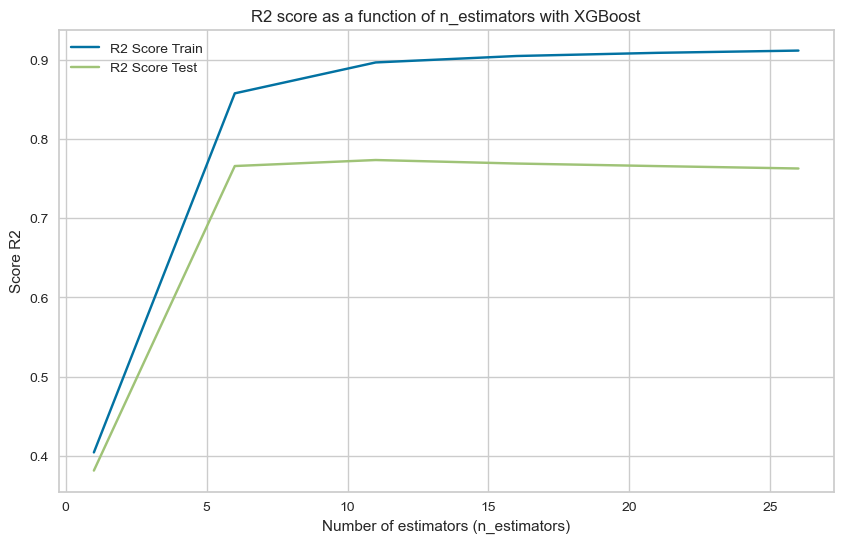

In [14]:
n_estimators_range = np.arange(1, 31, 5)  
train_scores = []
test_scores = []

for n in n_estimators_range:
    model = xgb.XGBRegressor(n_estimators=n, random_state=42, max_depth=16)
    model.fit(X_train_std, y_train)
    
    y_train_pred = model.predict(X_train_std)
    y_test_pred = model.predict(X_test_std)
    
    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label="R2 Score Train")
plt.plot(n_estimators_range, test_scores, label="R2 Score Test")
plt.xlabel("Number of estimators (n_estimators)")
plt.ylabel("Score R2")
plt.title("R2 score as a function of n_estimators with XGBoost")
plt.legend()
plt.grid(True)
plt.show()

In [103]:
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb",  xgb.XGBRegressor(n_estimators=6, random_state=42, max_depth=16)) 
])

xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('prectotcorr_transformer',
                                  FunctionTransformer(func=<function process_prectotcorr at 0x000002043DCA9F30>)),
                                 ('numeric_extraction',
                                  FunctionTransformer(func=<function extract_numeric_values at 0x00000204018C3490>)),
                                 ('feature_transform',
                                  ColumnTransformer(transformers=[('SKY_1',
                                                                   Pipeline(steps=[('scaler',
                                                                                    Standard...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=16, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=6, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [105]:
y_pred_train = xgb_pipeline.predict(X_train)
y_pred_test = xgb_pipeline.predict(X_test)

In [106]:
print(f"score train :  {r2_score(y_train, y_pred_train)}")
print(f"score test : {r2_score(y_test, y_pred_test)}")

score train :  0.9588026132430212
score test : 0.9469853732099236


In [108]:
scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5)

In [109]:
print(f"Scores de la cross-validation : {scores}")
print(f"Score moyen de la cross-validation : {scores.mean()}")

Scores de la cross-validation : [0.94198916 0.94595526 0.94339684 0.95380085 0.94562766]
Score moyen de la cross-validation : 0.9461539516578051


In [110]:
import joblib

# Enregistrez le pipeline
joblib.dump(xgb_pipeline, 'swpo_I.pkl')

['swpo_I.pkl']

In [373]:
train_max_error = []
test_max_error = []
train_mean_absolute_error = []
test_mean_absolute_error = [] 
train_mean_absolute_percentage_error = []
test_mean_absolute_percentage_error = [] 
train_mean_squared_error = []
test_mean_squared_error = [] 
train_mean_squared_relative_error = []
test_mean_squared_relative_error = [] 
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
#xgb_model = xgb.XGBRegressor(n_estimators=6, random_state=42, max_depth=16)

for train_index, test_index in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    xgb_model.fit(X_train_kf_std, y_train_kf)
    y_test_pred = xgb_model.predict(X_test_kf_std)
    y_train_pred = xgb_model.predict(X_train_kf_std) 
    
    me_test = max_error(y_test_kf, y_test_pred)
    me_train = max_error(y_train_kf, y_train_pred)
    mae_test = mean_absolute_error(y_test_kf, y_test_pred)
    mae_train = mean_absolute_error(y_train_kf, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test_kf, y_test_pred)
    mape_train = mean_absolute_percentage_error(y_train_kf, y_train_pred)
    mse_test = mean_squared_error(y_test_kf, y_test_pred)
    mse_train = mean_squared_error(y_train_kf, y_train_pred)
    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred) 
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)
    
    train_max_error.append(me_train)
    test_max_error.append(me_test)
    train_mean_absolute_error.append(mae_train)
    test_mean_absolute_error.append(mae_test) 
    train_mean_absolute_percentage_error.append(mape_train)
    test_mean_absolute_percentage_error.append(mape_test)
    train_mean_squared_error.append(mse_train)
    test_mean_squared_error.append(mse_test) 
    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train)    

Errors

In [49]:
print("########## Max error ############### :")
print(f"max_error test :  {np.mean(test_max_error):.2f}")
print(f"max_error train : {np.mean(train_max_error):.2f}")
print("########## mean absolute error ############### :")
print(f"mean_absolute_error test :  {np.mean(train_max_error):.2f}")
print(f"mean_absolute_error train : {np.mean(test_mean_absolute_error):.2f}")
print("########## mean absolute percentage error ############### :")
print(f"mean_absolute_percentage_error test :  {np.mean(test_mean_absolute_percentage_error):.2f}")
print(f"mean_absolute_percentage_error train : {np.mean(train_mean_absolute_percentage_error):.2f}")
print("########## mean squared error ############### :")
print(f"mean_squared_error test :  {np.mean(test_mean_squared_error):.2f}")
print(f"mean_squared_error train : {np.mean(train_mean_squared_error):.2f}")
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error):.2f}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error):.2f}")

########## Max error ############### :
max_error test :  42026.94
max_error train : 46682.32
########## mean absolute error ############### :
mean_absolute_error test :  46682.32
mean_absolute_error train : 772.85
########## mean absolute percentage error ############### :
mean_absolute_percentage_error test :  0.90
mean_absolute_percentage_error train : 0.74
########## mean squared error ############### :
mean_squared_error test :  2115354.47
mean_squared_error train : 1335354.63
########## relative squared error ############### :
mean_squared_relative_error test :  0.24
mean_squared_relative_error train : 0.15


Scores

In [374]:
print(f"score test :  {np.mean(r2_scores_test)}")
print(f"score train : {np.mean(r2_scores_train)}")

score test :  0.8818406373477103
score train : 0.927872711355047


Graphique

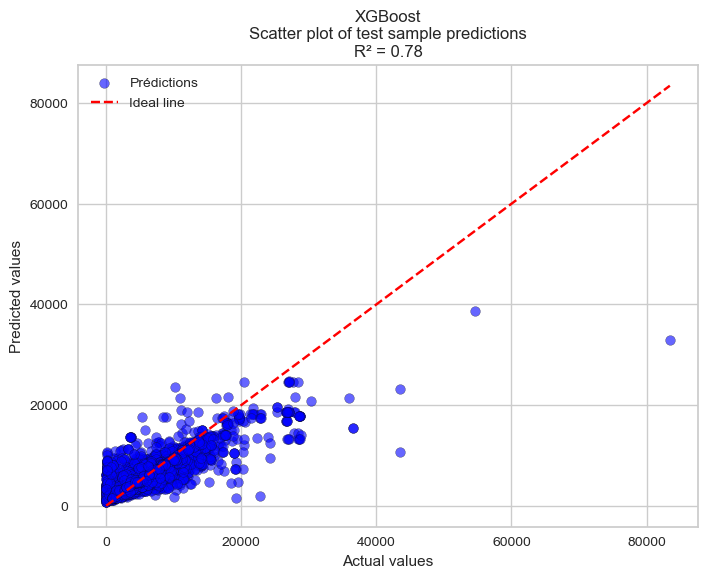

In [49]:
r2_xgb = np.mean(r2_scores_test)
y_test_pred_xgb = xgb_model.predict(X_test_std)

# Tracé du nuage de points
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.6, color='blue', edgecolors='k', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f"XGBoost\nScatter plot of test sample predictions\nR² = {r2_xgb:.2f}")
plt.legend()
plt.grid(True)
plt.show()

## KNN Regressor

In [34]:
from sklearn.neighbors import KNeighborsRegressor

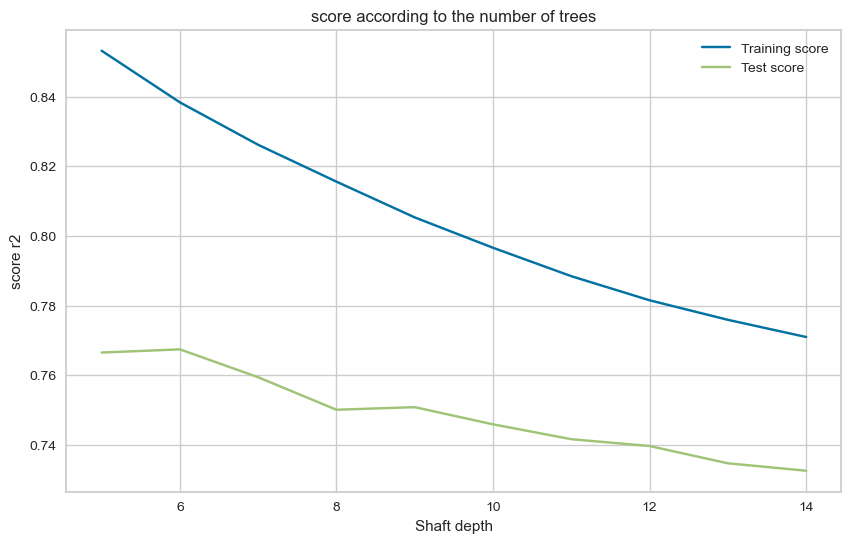

In [41]:
train_errors = []
test_errors = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
for depth in range(5, 15):
    neigh = KNeighborsRegressor(n_neighbors=depth)

    rse_scores = []  # RSE
    r2_scores_test = []
    r2_scores_train = []

    for train_index, test_index in kf.split(X):

        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

        scaler.fit(X_train_kf)
        X_train_kf_std = scaler.transform(X_train_kf)
        X_test_kf_std = scaler.transform(X_test_kf)

        neigh.fit(X_train_kf_std, y_train_kf)
        y_test_pred = neigh.predict(X_test_kf_std)
        y_train_pred = neigh.predict(X_train_kf_std)

        #rse = mean_squared_error(y_test_kf, y_test_pred)
        r2_test =  r2_score(y_test_kf, y_test_pred)
        r2_train = r2_score(y_train_kf, y_train_pred)
        #rse_scores.append(rse)
        r2_scores_test.append(r2_test)
        r2_scores_train.append(r2_train)

    #mean_rse = np.mean(rse_scores)
    mean_r2_test = np.mean(r2_scores_test)
    mean_r2_train = np.mean(r2_scores_train)
    test_errors.append(mean_r2_test)
    train_errors.append(mean_r2_train)
    
plt.figure(figsize=(10, 6))
plt.plot(range(5, 15), train_errors, label="Training score")
plt.plot(range(5, 15), test_errors, label="Test score")
plt.xlabel("Shaft depth") 
plt.ylabel("score r2")
plt.title("score according to the number of trees")
plt.legend()
plt.grid(True)
plt.show()

Model

In [35]:
train_max_error = []
test_max_error = []
train_mean_absolute_error = []
test_mean_absolute_error = [] 
train_mean_absolute_percentage_error = []
test_mean_absolute_percentage_error = [] 
train_mean_squared_error = []
test_mean_squared_error = [] 
train_mean_squared_relative_error = []
test_mean_squared_relative_error = [] 
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
neigh = KNeighborsRegressor(n_neighbors=6)

for train_index, test_index in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    neigh.fit(X_train_kf_std, y_train_kf)
    y_test_pred = neigh.predict(X_test_kf_std)
    y_train_pred = neigh.predict(X_train_kf_std) 
    
    me_test = max_error(y_test_kf, y_test_pred)
    me_train = max_error(y_train_kf, y_train_pred)
    mae_test = mean_absolute_error(y_test_kf, y_test_pred)
    mae_train = mean_absolute_error(y_train_kf, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test_kf, y_test_pred)
    mape_train = mean_absolute_percentage_error(y_train_kf, y_train_pred)
    mse_test = mean_squared_error(y_test_kf, y_test_pred)
    mse_train = mean_squared_error(y_train_kf, y_train_pred)
    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred) 
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)
    
    train_max_error.append(me_train)
    test_max_error.append(me_test)
    train_mean_absolute_error.append(mae_train)
    test_mean_absolute_error.append(mae_test) 
    train_mean_absolute_percentage_error.append(mape_train)
    test_mean_absolute_percentage_error.append(mape_test)
    train_mean_squared_error.append(mse_train)
    test_mean_squared_error.append(mse_test) 
    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train)    

Erros

In [36]:
print("########## Max error ############### :")
print(f"max_error test :  {np.mean(test_max_error)}")
print(f"max_error train : {np.mean(train_max_error)}")
print("########## mean absolute error ############### :")
print(f"mean_absolute_error test :  {np.mean(train_max_error)}")
print(f"mean_absolute_error train : {np.mean(test_mean_absolute_error)}")
print("########## mean absolute percentage error ############### :")
print(f"mean_absolute_percentage_error test :  {np.mean(test_mean_absolute_percentage_error)}")
print(f"mean_absolute_percentage_error train : {np.mean(train_mean_absolute_percentage_error)}")
print("########## mean squared error ############### :")
print(f"mean_squared_error test :  {np.mean(test_mean_squared_error)}")
print(f"mean_squared_error train : {np.mean(train_mean_squared_error)}")
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error)}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error)}")

########## Max error ############### :
max_error test :  40800.84
max_error train : 48079.780000000006
########## mean absolute error ############### :
mean_absolute_error test :  48079.780000000006
mean_absolute_error train : 679.2447819866878
########## mean absolute percentage error ############### :
mean_absolute_percentage_error test :  0.8195404622287563
mean_absolute_percentage_error train : 0.6674701340951703
########## mean squared error ############### :
mean_squared_error test :  2107112.1040398083
mean_squared_error train : 1439740.2995062093
########## relative squared error ############### :
mean_squared_relative_error test :  0.23578798312414975
mean_squared_relative_error train : 0.16118176994941863


Score

In [37]:
print(f"score test :  {np.mean(r2_scores_test)}")
print(f"score train : {np.mean(r2_scores_train)}")

score test :  0.7642120168758503
score train : 0.8388182300505814


## LIGHTGBM

In [27]:
#pip install lightgbm


     ---------------------------------------- 1.4/1.4 MB 2.3 MB/s eta 0:00:00


In [38]:
import lightgbm as lgb

In [39]:
train_errors = []
test_errors = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
for n in range(15, 200):
    lgbm = lgb.LGBMRegressor(n_estimators=n, reg_lambda = 5, max_depth = 17)

    rse_scores = []  # RSE
    r2_scores_test = []
    r2_scores_train = []

    for train_index, test_index in kf.split(X):

        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

        scaler.fit(X_train_kf)
        X_train_kf_std = scaler.transform(X_train_kf)
        X_test_kf_std = scaler.transform(X_test_kf)

        lgbm.fit(X_train_kf_std, y_train_kf)
        y_test_pred = lgbm.predict(X_test_kf_std)
        y_train_pred = lgbm.predict(X_train_kf_std)

        #rse = mean_squared_error(y_test_kf, y_test_pred)
        r2_test =  r2_score(y_test_kf, y_test_pred)
        r2_train = r2_score(y_train_kf, y_train_pred)
        #rse_scores.append(rse)
        r2_scores_test.append(r2_test)
        r2_scores_train.append(r2_train)

    #mean_rse = np.mean(rse_scores)
    mean_r2_test = np.mean(r2_scores_test)
    mean_r2_train = np.mean(r2_scores_train)
    test_errors.append(mean_r2_test)
    train_errors.append(mean_r2_train)
    
plt.figure(figsize=(10, 6))
plt.plot(range(15, 200), train_errors, label="Training score")
plt.plot(range(15, 200), test_errors, label="Test score")
plt.xlabel("Shaft n") 
plt.ylabel("score r2")
plt.title("Number of boosted trees to fit")
plt.legend()
plt.grid(True)
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5949.668333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5958.373365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5949.668333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5955.112228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5958.373365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5955.112228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5958.373365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5949.668333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5955.112228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5958.373365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5955.112228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5949.668333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5958.373365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5949.668333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5955.112228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5958.373365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5955.112228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5949.668333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5958.373365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5949.668333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5955.112228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5949.668333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21973
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5958.373365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the train set: 61167, number of used features: 87
[LightGBM] [Info] Start training from score 5949.668333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] 

KeyboardInterrupt: 

Model 

In [40]:
train_max_error = []
test_max_error = []
train_mean_absolute_error = []
test_mean_absolute_error = [] 
train_mean_absolute_percentage_error = []
test_mean_absolute_percentage_error = [] 
train_mean_squared_error = []
test_mean_squared_error = [] 
train_mean_squared_relative_error = []
test_mean_squared_relative_error = [] 
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
lgbm = lgb.LGBMRegressor(n_estimators=175, max_depth = 17)

for train_index, test_index in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    lgbm.fit(X_train_kf_std, y_train_kf)
    y_test_pred = lgbm.predict(X_test_kf_std)
    y_train_pred = lgbm.predict(X_train_kf_std) 
    
    me_test = max_error(y_test_kf, y_test_pred)
    me_train = max_error(y_train_kf, y_train_pred)
    mae_test = mean_absolute_error(y_test_kf, y_test_pred)
    mae_train = mean_absolute_error(y_train_kf, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test_kf, y_test_pred)
    mape_train = mean_absolute_percentage_error(y_train_kf, y_train_pred)
    mse_test = mean_squared_error(y_test_kf, y_test_pred)
    mse_train = mean_squared_error(y_train_kf, y_train_pred)
    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred) 
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)
    
    train_max_error.append(me_train)
    test_max_error.append(me_test)
    train_mean_absolute_error.append(mae_train)
    test_mean_absolute_error.append(mae_test) 
    train_mean_absolute_percentage_error.append(mape_train)
    test_mean_absolute_percentage_error.append(mape_test)
    train_mean_squared_error.append(mse_train)
    test_mean_squared_error.append(mse_test) 
    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train)    

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5948.452618
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21975
[LightGBM] [Info] Number of data points in the 

Errors

In [41]:
print("########## Max error ############### :")
print(f"max_error test :  {np.mean(test_max_error)}")
print(f"max_error train : {np.mean(train_max_error)}")
print("########## mean absolute error ############### :")
print(f"mean_absolute_error test :  {np.mean(train_max_error)}")
print(f"mean_absolute_error train : {np.mean(test_mean_absolute_error)}")
print("########## mean absolute percentage error ############### :")
print(f"mean_absolute_percentage_error test :  {np.mean(test_mean_absolute_percentage_error)}")
print(f"mean_absolute_percentage_error train : {np.mean(train_mean_absolute_percentage_error)}")
print("########## mean squared error ############### :")
print(f"mean_squared_error test :  {np.mean(test_mean_squared_error)}")
print(f"mean_squared_error train : {np.mean(train_mean_squared_error)}")
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error)}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error)}")

########## Max error ############### :
max_error test :  40533.11223156366
max_error train : 50130.59096052145
########## mean absolute error ############### :
mean_absolute_error test :  50130.59096052145
mean_absolute_error train : 834.6879795231516
########## mean absolute percentage error ############### :
mean_absolute_percentage_error test :  0.9434593711522128
mean_absolute_percentage_error train : 0.8810000388421736
########## mean squared error ############### :
mean_squared_error test :  2213995.2480374733
mean_squared_error train : 1834507.0538420968
########## relative squared error ############### :
mean_squared_relative_error test :  0.24784562990804834
mean_squared_relative_error train : 0.20537031253762633


Scores

In [42]:
print(f"score test :  {np.mean(r2_scores_test)}")
print(f"score train : {np.mean(r2_scores_train)}")

score test :  0.7521543700919515
score train : 0.7946296874623736


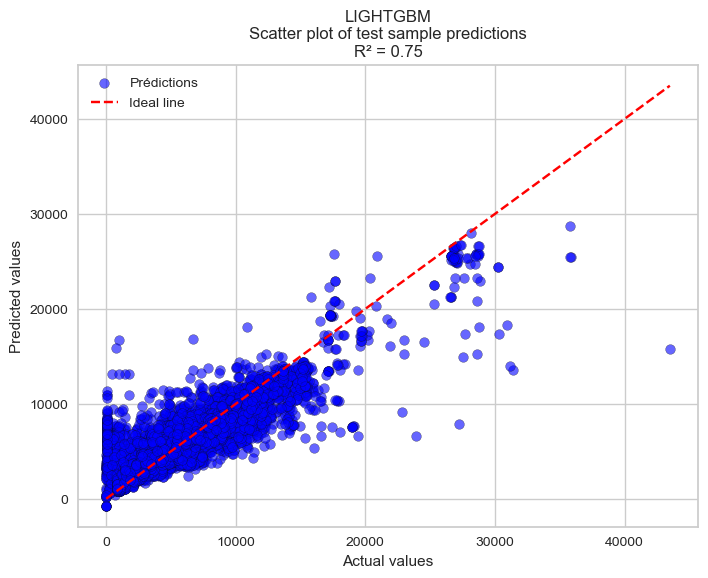

In [43]:
r2_lgbm = np.mean(r2_scores_test)
y_test_pred_lgbm = lgbm.predict(X_test_std)

# Tracé du nuage de points
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_lgbm, alpha=0.6, color='blue', edgecolors='k', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f"LIGHTGBM\nScatter plot of test sample predictions\nR² = {r2_lgbm:.2f}")
plt.legend()
plt.grid(True)
plt.show()

## StackingRegressor

In [44]:
from sklearn.ensemble import StackingRegressor

In [51]:
estimators = [('xgb',xgb.XGBRegressor(n_estimators=45, learning_rate=0.1, max_depth=15)),
              ('KNN', KNeighborsRegressor(n_neighbors=6))]

Model

In [52]:
final_estimator =lgb.LGBMRegressor(n_estimators=175,max_depth = 17) 
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator)
reg.fit(X_train_std, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 53520, number of used features: 2
[LightGBM] [Info] Start training from score 5948.829627


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=15,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=45, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('KNN', KNeighborsRegressor(n_neighbors=6))],
                  final_estimator=LGBMRegressor(max_depth=17, n_estimators=175))

In [53]:
y_pred_test = reg.predict(X_test_std)
y_pred_train = reg.predict(X_train_std)
print('R2 score train : {:.2f}'.format(r2_score(y_test, y_pred_test)))
print('R2 score test : {:.2f}'.format(r2_score(y_train, y_pred_train)))

R2 score train : 0.78
R2 score test : 0.87


# Cross validation

In [54]:
lgbm_scores_test = []
lgbm_scores_train = []
reg_scores_test = []
reg_scores_train = []
neigh_scores_test = []
neigh_scores_train = []
xgb_model_scores_test = []
xgb_model_scores_train = []

lgbm_rse_test = []
lgbm_rse_train = []
reg_rse_test = []
reg_rse_train = []
neigh_rse_test = []
neigh_rse_train = []
xgb_model_rse_test = []
xgb_model_rse_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()

for train_index, test_index in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    lgbm.fit(X_train_kf_std, y_train_kf)
    reg.fit(X_train_kf_std, y_train_kf)
    neigh.fit(X_train_kf_std, y_train_kf)
    xgb_model.fit(X_train_kf_std, y_train_kf)
    
    y_test_pred_lgbm = lgbm.predict(X_test_kf_std)
    y_train_pred_lgbm = lgbm.predict(X_train_kf_std) 
    y_test_pred_reg = reg.predict(X_test_kf_std)
    y_train_pred_reg = reg.predict(X_train_kf_std)  
    y_test_pred_neigh = neigh.predict(X_test_kf_std)
    y_train_pred_neigh = neigh.predict(X_train_kf_std)  
    y_test_pred_xgb_model = xgb_model.predict(X_test_kf_std)
    y_train_pred_xgb_model = xgb_model.predict(X_train_kf_std) 
  
  
    rse_train_xgb_model = 1- r2_score(y_train_kf, y_train_pred_xgb_model)
    rse_test_xgb_model = 1- r2_score(y_test_kf, y_test_pred_xgb_model) 
    r2_test_xgb_model =  r2_score(y_test_kf, y_test_pred_xgb_model)
    r2_train_xgb_model = r2_score(y_train_kf, y_train_pred_xgb_model)
    
    rse_train_reg = 1- r2_score(y_train_kf, y_train_pred_reg)
    rse_test_reg = 1- r2_score(y_test_kf, y_test_pred_reg) 
    r2_test_reg =  r2_score(y_test_kf, y_test_pred_reg)
    r2_train_reg = r2_score(y_train_kf, y_train_pred_reg)
    
    rse_train_neigh = 1- r2_score(y_train_kf, y_train_pred_neigh)
    rse_test_neigh = 1- r2_score(y_test_kf, y_test_pred_neigh) 
    r2_test_neigh =  r2_score(y_test_kf, y_test_pred_neigh)
    r2_train_neigh = r2_score(y_train_kf, y_train_pred_neigh)
    
    rse_train_lgbm = 1- r2_score(y_train_kf, y_train_pred_lgbm)
    rse_test_lgbm = 1- r2_score(y_test_kf, y_test_pred_lgbm)    
    r2_test_lgbm =  r2_score(y_test_kf, y_test_pred_lgbm)
    r2_train_lgbm = r2_score(y_train_kf, y_train_pred_lgbm)
    
    lgbm_scores_test.append(r2_test_lgbm)
    lgbm_scores_train.append(r2_train_lgbm)
    lgbm_rse_test.append(rse_test_lgbm)
    lgbm_rse_train.append(rse_train_lgbm)
    
    reg_rse_test.append(rse_test_reg)
    reg_rse_train.append(rse_train_reg)
    reg_scores_test.append(r2_test_reg)
    reg_scores_train.append(r2_train_reg)
    
    neigh_rse_test.append(rse_test_neigh)
    neigh_rse_train.append(rse_train_neigh)
    neigh_scores_test.append(r2_test_neigh)
    neigh_scores_train.append(r2_train_neigh)
    
    xgb_model_rse_test.append(rse_test_xgb_model)
    xgb_model_rse_train.append(rse_train_xgb_model)
    xgb_model_scores_test.append(r2_test_xgb_model)
    xgb_model_scores_train.append(r2_train_xgb_model)    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 2
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the tra

KeyboardInterrupt: 

Results

In [72]:
print("########## lightgbm MODEL ############### :")
print(f"rse test :  {np.mean(lgbm_rse_test)}")
print(f"rse train :  {np.mean(lgbm_rse_train)}")
print(f"score test :  {np.mean(lgbm_scores_test)}")
print(f"score train :  {np.mean(lgbm_scores_train)}")

print("########## KNN Regressor ############### :")
print(f"rse test :  {np.mean(neigh_rse_test)}")
print(f"rse train :  {np.mean(neigh_rse_train)}")
print(f"score test :  {np.mean(neigh_scores_test)}")
print(f"score train :  {np.mean(neigh_scores_train)}")

print("########## XGB BOOST MODEL ############### :")
print(f"rse test :  {np.mean(xgb_model_rse_test)}")
print(f"rse train :  {np.mean(xgb_model_rse_train)}")
print(f"score test :  {np.mean(xgb_model_scores_test)}")
print(f"score train :  {np.mean(xgb_model_scores_train)}")

print("########## StackingRegressor MODEL ############### :")
print(f"rse test :  {np.mean(reg_rse_test)}")
print(f"rse train :  {np.mean(reg_rse_train)}")
print(f"score test :  {np.mean(reg_scores_test)}")
print(f"score train :  {np.mean(reg_scores_train)}")

########## lightgbm MODEL ############### :
rse test :  0.24784562990804834
rse train :  0.20537031253762633
score test :  0.7521543700919515
score train :  0.7946296874623736
########## KNN Regressor ############### :
rse test :  0.23581361874464218
rse train :  0.16117827604657603
score test :  0.7641863812553578
score train :  0.838821723953424
########## XGB BOOST MODEL ############### :
rse test :  0.24931536905468601
rse train :  0.16446375110822806
score test :  0.750684630945314
score train :  0.835536248891772
########## StackingRegressor MODEL ############### :
rse test :  0.44761037605427106
rse train :  0.3932873767026275
score test :  0.5523896239457289
score train :  0.6067126232973725


## The best(s) model(s)

#### The bests models are XGB BOOST MODEL and KNN Regressor

##### KNN Model

In [73]:
train_mean_squared_relative_error = []
test_mean_squared_relative_error = [] 
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
neigh = KNeighborsRegressor(n_neighbors=6)

for train_index, test_index in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    neigh.fit(X_train_kf_std, y_train_kf)
    y_test_pred = neigh.predict(X_test_kf_std)
    y_train_pred = neigh.predict(X_train_kf_std) 
    

    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred) 
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)
    
    
    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train) 

In [76]:
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error):.2f}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error):.2f}")
print("########## SCORE ############### :")
print(f"score test :  {np.mean(r2_scores_test):.2f}")
print(f"score train : {np.mean(r2_scores_train):.2f}")


########## relative squared error ############### :
mean_squared_relative_error test :  0.24
mean_squared_relative_error train : 0.16
########## SCORE ############### :
score test :  0.76
score train : 0.84


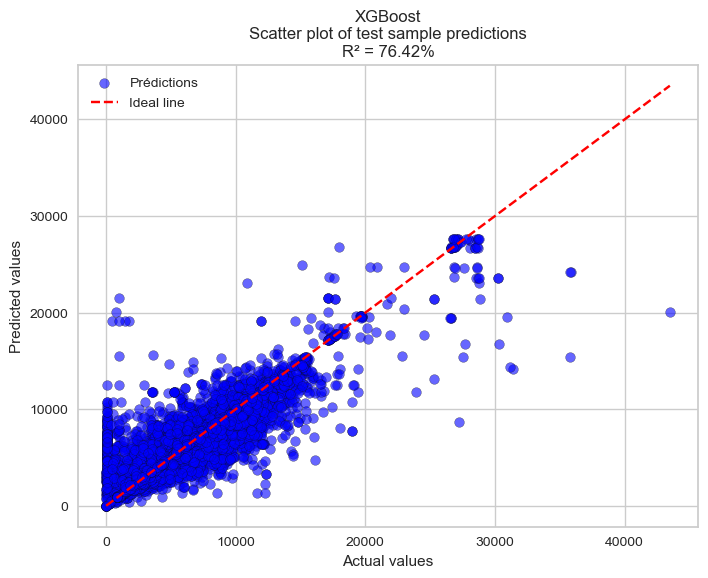

In [79]:
r2_knn = np.mean(r2_scores_test)
y_test_pred_knn = neigh.predict(X_test_std)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_knn, alpha=0.6, color='blue', edgecolors='k', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f"KNN\nScatter plot of test sample predictions\nR² = {r2_knn*100:.2f}%")
plt.legend()
plt.grid(True)
plt.show()

##### XGB BOOST MODEL

In [81]:
train_mean_squared_relative_error = []
test_mean_squared_relative_error = [] 
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
xgb_model = xgb.XGBRegressor(n_estimators=5, random_state=42, max_depth=17)

for train_index, test_index in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    xgb_model.fit(X_train_kf_std, y_train_kf)
    y_test_pred = xgb_model.predict(X_test_kf_std)
    y_train_pred = xgb_model.predict(X_train_kf_std) 
    

    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred) 
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)
    
    
    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train) 

In [ ]:
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error):.2f}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error):.2f}")
print("########## SCORE ############### :")
print(f"score test :  {np.mean(r2_scores_test):.2f}")
print(f"score train : {np.mean(r2_scores_train):.2f}")

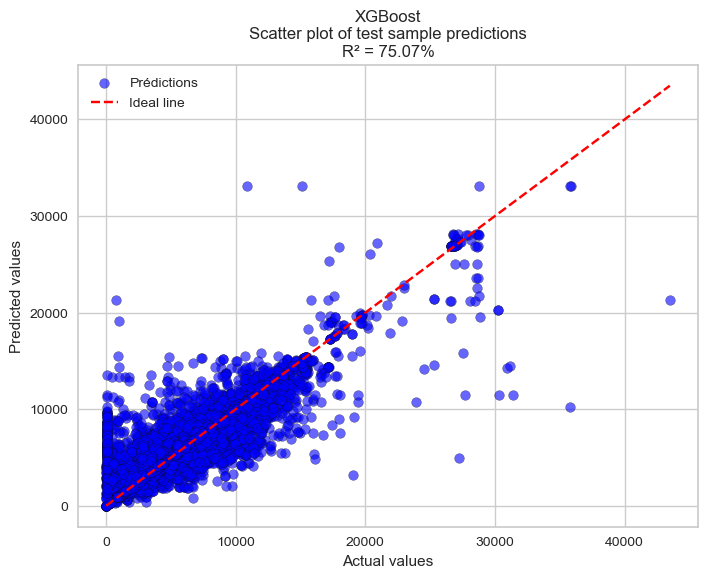

In [82]:
r2_xgb = np.mean(r2_scores_test)
y_test_pred_xgb = neigh.predict(X_test_std)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.6, color='blue', edgecolors='k', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f"XGBoost\nScatter plot of test sample predictions\nR² = {r2_xgb*100:.2f}%")
plt.legend()
plt.grid(True)
plt.show()

# Pipepline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin